# Requirements

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install kapre==0.1.7
%pip install soundfile

  Created wheel for kapre: filename=kapre-0.1.7-cp36-none-any.whl size=11663 sha256=73f6c0c1d659bd62e971745f145cc9914bf814b866ea6c822e73f04e3d534df9
  Stored in directory: /root/.cache/pip/wheels/80/b0/36/f8ef462364784fcb1b7782e73ec59821162318ec28556516b6
Successfully built kapre
  Found existing installation: kapre 0.1.3.1
    Uninstalling kapre-0.1.3.1:
      Successfully uninstalled kapre-0.1.3.1


In [ ]:
import os
import numpy as np
import kapre
import librosa
import random
import tensorflow as tf
import soundfile as sf
from tensorflow.keras import layers as L
from tensorflow.keras.models import Sequential,Model
from kapre.time_frequency import Melspectrogram
from kapre.utils import Normalization2D
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

# Generate data

In [ ]:
data_dir = '/content/drive/My Drive/Colab Notebooks/Data/'
os.chdir(data_dir)
data_x = []
data_y = []
for a,i in enumerate(['forward','back','left','right','stop']):
    # print(a,i)
    lis = os.listdir(data_dir+i)
    for j in lis:
        l,sr = sf.read(data_dir+i+'/'+j)
        # arr = np.zeros()
        arr = l[8000:40000]
        if arr.size < 32000:
          l = np.pad(arr,(0,32000-arr.size),'constant')
          # print(arr.size,l.size)
        else:
          l = arr
        # l = list(l)
        data_x.append(l)
        # print(len(data_x))
        data_y.append(a)
    print(i," Done")


data_x = np.array(data_x)
# print(data_x.shape)
data_y = np.array(data_y)
np.save('x.npy',data_x)
np.save('y.npy',data_y)
# print(data_x.size,data_y.size)
# os.listdir()
# a = np.array([1,2,34,5,6,7,8,9])
# b = np.zeros((12))
# b[0:min(12,a.size)] = a[5:min(12,a.size)
# print(data_x[1:10])

forward  Done
back  Done
left  Done
right  Done
stop  Done
(413, 32000)
[[-0.02114868  0.01364136  0.01370239 ...  0.          0.
   0.        ]
 [-0.00860596  0.0055542   0.00567627 ...  0.          0.
   0.        ]
 [-0.0211792   0.01364136  0.01367188 ...  0.          0.
   0.        ]
 ...
 [ 0.00268555  0.01800537  0.02325439 ...  0.17269897  0.15341187
   0.13067627]
 [-0.01965332  0.01269531  0.01266479 ...  0.          0.
   0.        ]
 [ 0.00869751 -0.0055542  -0.0057373  ...  0.          0.
   0.        ]]


In [ ]:
data_x = np.load('x.npy')
data_y = np.load('y.npy')
# print(data_y)
from sklearn.model_selection import train_test_split
tr_x,te_x, tr_y,te_y = train_test_split(data_x,data_y,stratify=data_y,random_state=123,test_size=0.2)

In [ ]:
x_train = []
y_train = []
for i,j in enumerate(tr_x):
    # print(len(j))
    x= len(j)
    p = 50000-x
    for y in range(1 ,p, 1000):
        nx = np.zeros(50000)
        nx[y:y+x] =j
        x_train.append(nx)
        y_train.append(tr_y[i])
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = []
y_test = []
for i,j in enumerate(te_x):
    x= len(j)
    p = 50000-x
    for y in range(1 ,p, 1000):
        nx = np.zeros(50000)
        nx[y:y+x] =j
        x_test.append(nx)
        y_test.append(te_y[i])
x_test = np.array(x_test)
y_test = np.array(y_test)
# print(type(x_test))

np.save('x_train.npy',x_train)
np.save('y_train.npy',y_train)
np.save('x_test.npy',x_test)
np.save('y_test.npy',y_test)

# Extract Features

In [ ]:
mfcc = Sequential()
mfcc.add(L.Reshape((1, -1)))
mfcc.add(Melspectrogram(padding='same', sr=16000, n_mels=39, n_dft = 1024,
                        power_melgram=2.0, return_decibel_melgram=True,
                        trainable_fb=False, trainable_kernel=False,
                        name='mel_stft'))
mfcc.add(Normalization2D(str_axis='freq'))
mfcc.add(L.Permute((2, 1, 3)))

x_train = mfcc.predict(x_train)
x_train.shape

x_test = mfcc.predict(x_test)
x_test.shape

np.save('mfcc_train.npy',x_train)
np.save('mfcc_test.npy',x_test)

# Loading data

In [ ]:
# Change the directory 
# data_dir = '/content/drive/My Drive/GVV/Pradeep_16/'
x_train = np.load(data_dir+'mfcc_train.npy')
y_train = np.load(data_dir+'y_train.npy')
x_test = np.load(data_dir+'mfcc_test.npy')
y_test = np.load(data_dir+'y_test.npy')

# Model

In [ ]:
# https://github.com/douglas125/SpeechCmdRecognition/blob/master/SpeechModels.py

os.environ['PYTHONHASHSEED']='123'
np.random.seed(123)
random.seed(123)
tf.random.set_seed(123)

def AttentionModel(sr=16000, iLen=25000):
    
    inputs = L.Input(x_train.shape[1:], name='Input')

    x = L.Conv2D(10, (5, 1), activation='relu', padding='same', name='Conv1')(inputs)
    x = L.BatchNormalization(name='BN1')(x)
    x = L.Conv2D(1, (5, 1), activation='relu', padding='same', name='Conv2')(x)
    x = L.BatchNormalization(name='BN2')(x)

    x = L.Reshape(x.shape[1:-1],name='Squeeze')(x)

    n_units = 64
    x = L.LSTM(n_units, return_sequences=True, name='LSTM_Sequences')(x)  

    # Calculate Unit Importance
    xLast = L.Lambda(lambda q: q[:, -1], name='FinalSequence')(x)  # [b_s, vec_dim]
    xLast = L.Dense(xLast.shape[-1], name='UnitImportance')(xLast)

    # Calculate attention
    attScores = L.Dot(axes=[1, 2],name='AttentionScores')([xLast, x])
    attScores = L.Softmax(name='AttentionSoftmax')(attScores)  

    x = L.Dot(axes=[1, 1], name='AttentionVector')([attScores, x])  
    x = L.Dense(32, activation='relu', name='FC')(x)
    outputs = L.Dense(5, activation='softmax', name='Output')(x)
    model = Model(inputs=[inputs], outputs=[outputs], name='Attention')

    return model

model = AttentionModel()
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])

In [ ]:
model.summary()

Model: "Attention"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 98, 39, 1)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 98, 39, 10)   60          Input[0][0]                      
__________________________________________________________________________________________________
BN1 (BatchNormalization)        (None, 98, 39, 10)   40          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 98, 39, 1)    51          BN1[0][0]                        
__________________________________________________________________________________________

# Train Model

In [ ]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),verbose=1,epochs=5,shuffle=True,batch_size=15)

Epoch 1/5
396/396 [==============================] - 4s 11ms/step - loss: 0.2751 - sparse_categorical_accuracy: 0.9071 - val_loss: 0.1161 - val_sparse_categorical_accuracy: 0.9625
Epoch 2/5
396/396 [==============================] - 4s 9ms/step - loss: 0.0029 - sparse_categorical_accuracy: 0.9998 - val_loss: 0.0252 - val_sparse_categorical_accuracy: 0.9906
Epoch 3/5
396/396 [==============================] - 4s 9ms/step - loss: 4.9879e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0254 - val_sparse_categorical_accuracy: 0.9913
Epoch 4/5
396/396 [==============================] - 4s 10ms/step - loss: 7.6534e-04 - sparse_categorical_accuracy: 0.9998 - val_loss: 0.0022 - val_sparse_categorical_accuracy: 1.0000
Epoch 5/5
396/396 [==============================] - 4s 9ms/step - loss: 1.4469e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0016 - val_sparse_categorical_accuracy: 1.0000


# Check attention

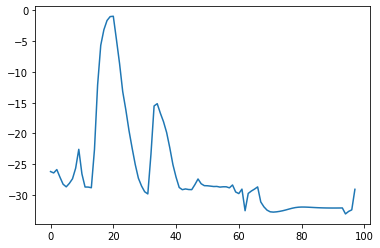

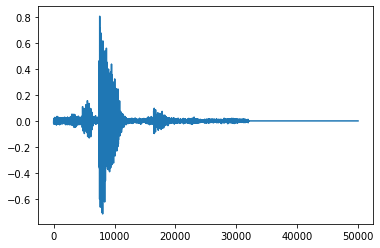

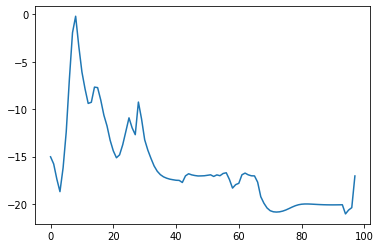

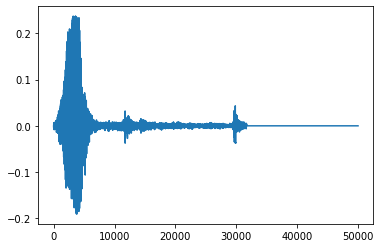

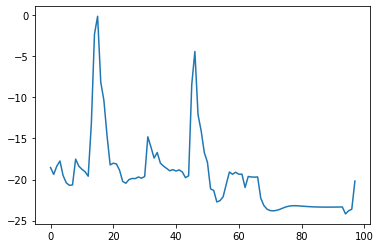

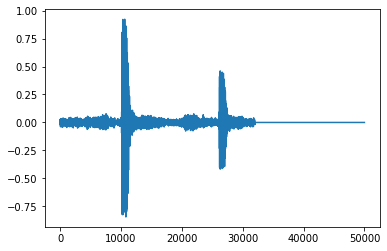

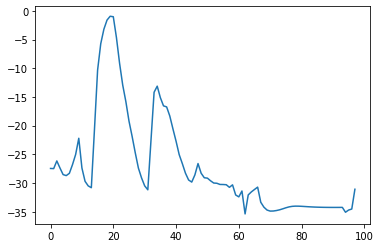

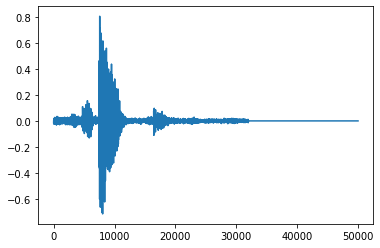

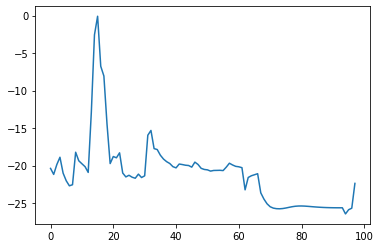

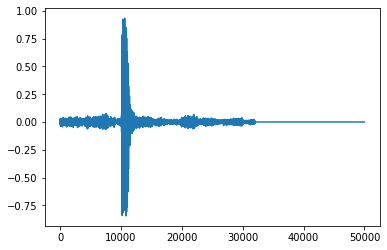

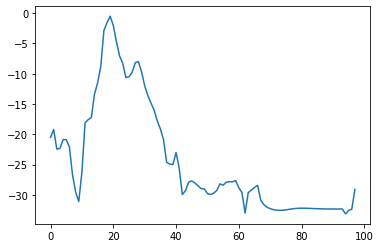

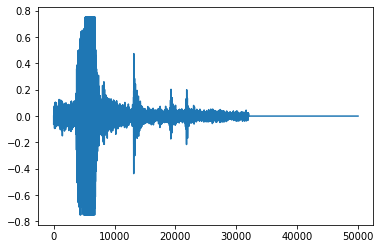

In [ ]:
from matplotlib import pyplot as plt
model2 = Model(inputs=model.input, outputs=[model.get_layer('Output').output, 
                                            model.get_layer('AttentionSoftmax').output])
# data_dir = '/content/drive/My Drive/GVV/Pradeep_16/'

a,b = model2.predict(x_test)
xx_test = np.load(data_dir+'x_test.npy')
for aid in range(0,100,18):
    plt.plot(range(len(b[aid])), np.log(b[aid]))
    plt.show()
    plt.plot(range(len(xx_test[aid])),xx_test[aid])
    plt.show()